**Imports**

In [75]:
import pandas as pd
import numpy as np
import networkx as nx
import zlib
import pickle
import os
import matplotlib.pyplot as plt
from itertools import combinations
import sys
import math


compressed_sizes = {}


**Load dataset**

In [2]:
def load_dataset(file_path):
    df = pd.read_csv(file_path, sep="::", engine="python", names=["user_id", "item_id", "rating", "timestamp", "normalized_rating"])
    return df

**Dictionary with pre-computed values**

In [3]:
def compute_compressed_sizes(user_ratings):
    
    for user, ratings in user_ratings.items():
        u_string = "".join(f"{k}:{v}" for k, v in sorted(ratings.items()))
        compressed_sizes[u_string] = len(zlib.compress(u_string.encode()))
    
    return compressed_sizes


**Similarities**

In [4]:
def linear_similarity(ratings_u, ratings_v):
    common_items = set(ratings_u.keys()).intersection(set(ratings_v.keys()))
    if not common_items:
        return 0  # If no common items, similarity is 0

    diff_sum = sum(abs(ratings_u[i] - ratings_v[i]) for i in common_items)
    ls_value = 1 - (diff_sum / len(common_items))
    return max(0, ls_value)  # Ensure similarity is non-negative

# Compression Similarity with precomputed sizes
def compression_similarity(ratings_u, ratings_v):
    u_string = "".join(f"{k}:{v}" for k, v in sorted(ratings_u.items()))
    v_string = "".join(f"{k}:{v}" for k, v in sorted(ratings_v.items()))
    c_uv = len(zlib.compress((u_string + v_string).encode()))
    c_u = compressed_sizes[u_string]
    c_v = compressed_sizes[v_string]
    return 1 - (c_uv - min(c_u, c_v)) / max(c_u, c_v)

# Kolmogorov Similarity with precomputed sizes
def kolmogorov_similarity(ratings_u, ratings_v):
    u_string = "".join(f"{k}:{v}" for k, v in sorted(ratings_u.items()))
    v_string = "".join(f"{k}:{v}" for k, v in sorted(ratings_v.items()))
    c_u = compressed_sizes[u_string]
    c_v = compressed_sizes[v_string]
    return 1 / (1 + abs(c_u - c_v))


**Simlarity Matrix and graph**

In [53]:
# Compute user similarity matrix and construct graph (with precomputed sizes)
def compute_similarity_matrix(user_ratings, similarity_measure, compressed_sizes):
    similarity_graph = nx.Graph()
    for (u, v) in combinations(user_ratings.keys(), 2):
        sim = similarity_measure(user_ratings[u], user_ratings[v])
        if sim > 0.99:
            similarity_graph.add_edge(u, v, weight=sim)
    return similarity_graph

# Detect user clusters from similarity graph
def detect_groups(similarity_graph):
    return list(nx.connected_components(similarity_graph))

**Reputation-based intra-clustering**

In [78]:
def compute_cluster_ratings(df, user_groups):
    """ Compute initial ratings per cluster based only on the items rated by users in the cluster. """
    cluster_item_ratings = {}

    # compute this for all user user groups(clusters)
    for cluster_idx, user_set in enumerate(user_groups, start=1): 
        cluster_df = df[df["user_id"].isin(user_set)] # filters dataset to only show rows for the users in specified cluster
        item_avg_ratings = cluster_df.groupby("item_id")["normalized_rating"].mean().to_dict()  #groups by the "item_id" column and calculates mean from normalized_ratings column.
        cluster_item_ratings[cluster_idx] = item_avg_ratings

    return cluster_item_ratings

def fill_missing_ratings(cluster_item_ratings, total_items=1682):
    """Fill missing ratings for the 3 largest clusters by borrowing from other clusters(starting by the bigger ones)."""
    sorted_clusters = sorted(cluster_item_ratings.keys(), key=lambda c: len(cluster_item_ratings[c]), reverse=True) # sort cluster based on size
    top_clusters = sorted_clusters[:3] # get 3 biggest clusters

    for cluster in top_clusters: # borrow only for the 3 biggest clusters
        missing_items = set(range(1, total_items + 1)) - set(cluster_item_ratings[cluster].keys()) #find which items are missing from each cluster
        for item in missing_items:
            for donor_cluster in sorted_clusters:
                if item in cluster_item_ratings[donor_cluster]: #search for missing itesm in other clusters
                    cluster_item_ratings[cluster][item] = cluster_item_ratings[donor_cluster][item]
                    break # if you find the item stop looking for it
        cluster_item_ratings[cluster] = dict(sorted(cluster_item_ratings[cluster].items())) #finally sort the items within each cluster
        print(f"CLUSTER {cluster}: {len(cluster_item_ratings[cluster])} items rated", cluster_item_ratings[cluster])
    
    return cluster_item_ratings

def compute_reputation_adjusted_ratings(df, cluster_item_ratings, user_groups, lambda_factor=0.95, tol=1e-6):
    """ Iteratively adjust ratings based on user reputation until convergence. """

    # Sort clusters based on size (number of items rated) in descending order.
    sorted_clusters = sorted(cluster_item_ratings.keys(), key=lambda c: len(cluster_item_ratings[c]), reverse=True)

    # Select the top 3 largest clusters.
    top_clusters = sorted_clusters[:3]

    # Initialize previous ratings with the initial ratings for the top clusters.
    prev_ratings = {c: cluster_item_ratings[c].copy() for c in top_clusters}

    converged = False

    # Iterate until convergence (ratings dont change after one iteration).
    while not converged:
        new_ratings = {}  
        converged = True 

        # Iterate through each of the top clusters.
        for cluster in top_clusters:
            # Get all user IDs belonging to the current cluster.
            cluster_users = user_groups[cluster - 1]  # -1 because user_groups is zero indexed but cluster index starts at 1.

            # Filter the DataFrame to include only ratings from users in the current cluster.
            cluster_df = df[df["user_id"].isin(cluster_users)]

            # Copy the previous ratings for this cluster to use as a starting point.
            item_ratings = prev_ratings[cluster].copy()

            user_reputation = {}  # Store the reputation scores for users in this cluster.

            # Compute reputation scores for each user in the cluster.
            for user in cluster_users:
                # Filter the cluster's DataFrame to get ratings from the current user.
                user_ratings = cluster_df[cluster_df["user_id"] == user]

                # Calculate the total difference between the user's ratings and the current item ratings.
                errors = [(user_ratings[user_ratings["item_id"] == item]["normalized_rating"].values[0] - item_ratings[item])
                          for item in user_ratings["item_id"] if item in item_ratings]
                          
                # Calculate the total error, divided by number of ratings the user has.
                avg_error = np.sum(errors) / len(user_ratings) if errors else 0

                # Calculate the user's reputation score. Ensure it's non-negative.
                user_reputation[user] = max(0, 1 - lambda_factor * avg_error)

            # Compute new weighted averages for item ratings based on user reputations.
            new_item_ratings = item_ratings.copy()  # Start with existing ratings.

            # Iterate through each item in the cluster's item ratings.
            for item in item_ratings.keys():
                # Filter the cluster's DataFrame to get ratings for the current item.
                ratings = cluster_df[cluster_df["item_id"] == item]

                # Extract the reputation weights and rating values for users who rated the current item.
                weights = np.array([user_reputation[user] for user in ratings["user_id"] if user in user_reputation])
                values = np.array([ratings[ratings["user_id"] == user]["normalized_rating"].values[0] for user in ratings["user_id"] if user in user_reputation])
       
                # Calculate the new weighted average rating for the item.
                if len(weights) > 0 and sum(weights) > 0:
                    new_item_ratings[item] = np.dot(weights, values) / len(weights)

            # Store the new item ratings for the cluster.
            new_ratings[cluster] = new_item_ratings

            # Check for convergence: compare new ratings with previous ratings.
            print("ITERATION")
            for item in new_item_ratings.keys():
                # If the difference between the new rating and the previous rating exceeds the tolerance,
                # set the convergence flag to False.
                if abs(new_item_ratings[item] - prev_ratings[cluster].get(item, 0)) > tol:
                    converged = False

        # Update the previous ratings with the newly computed ratings for the next iteration.
        prev_ratings = new_ratings.copy()

    # Print the final converged ratings.
    print("new_ratings: ", new_ratings)

    # Return the converged ratings.
    return new_ratings


def round_and_average_cluster_ratings(cluster_ratings):
    def round_to_one_decimal(value):
        """Helper function to round according to the specified rules."""
        if value >= 0.95:
            return 1.0
        else:
            return round(value, 1)

    # Create a DataFrame from the input dictionary
    df = pd.DataFrame.from_dict(cluster_ratings, orient='index').T

    # Apply the rounding function to all columns
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]): #Ensure it is numeric before trying to round.
            df[col] = df[col].apply(round_to_one_decimal)

    # Calculate the average rating for each item across all clusters
    item_averages = df.mean(axis=1)

    # Return the result as a dictionary
    return item_averages.to_dict()



**Main function**

In [81]:

# Main execution
file_path = "/home/martim/Desktop/tese/datasets/ml-100k/sorted_normalized_rating_movielns_100k.dat"
df = load_dataset(file_path)

# Prepare user ratings
user_ratings = {user: dict(zip(group["item_id"], group["normalized_rating"])) for user, group in df.groupby("user_id")}

print("\nuser_ratings: ", user_ratings)
# Compute or load compressed sizes
compressed_sizes = compute_compressed_sizes(user_ratings)
print("comprimido")


user_ratings:  {1: {61: 0.8, 189: 0.6, 33: 0.8, 160: 0.8, 20: 0.8, 202: 1.0, 171: 1.0, 265: 0.8, 155: 0.4, 117: 0.6, 47: 0.8, 222: 0.8, 253: 1.0, 113: 1.0, 227: 0.8, 17: 0.6, 90: 0.8, 64: 1.0, 92: 0.6, 228: 1.0, 266: 0.2, 121: 0.8, 114: 1.0, 132: 0.8, 74: 0.2, 134: 0.8, 98: 0.8, 186: 0.8, 221: 1.0, 84: 0.8, 31: 0.6, 70: 0.6, 60: 1.0, 177: 1.0, 27: 0.4, 260: 0.2, 145: 0.4, 174: 1.0, 159: 0.6, 82: 1.0, 56: 0.8, 272: 0.6, 80: 0.8, 229: 0.8, 140: 0.2, 225: 0.4, 235: 1.0, 120: 0.2, 125: 0.6, 215: 0.6, 6: 1.0, 104: 0.2, 49: 0.6, 206: 0.8, 76: 0.8, 72: 0.8, 185: 0.8, 96: 1.0, 213: 0.4, 233: 0.4, 258: 1.0, 81: 1.0, 78: 0.2, 212: 0.8, 143: 0.2, 151: 0.8, 51: 0.8, 175: 1.0, 107: 0.8, 218: 0.6, 209: 0.8, 259: 0.2, 108: 1.0, 262: 0.6, 12: 1.0, 14: 1.0, 97: 0.6, 44: 1.0, 53: 0.6, 163: 0.8, 210: 0.8, 184: 0.8, 157: 0.8, 201: 0.6, 150: 1.0, 183: 1.0, 248: 0.8, 208: 1.0, 128: 0.8, 242: 1.0, 148: 0.4, 112: 0.2, 193: 0.8, 264: 0.4, 219: 0.2, 232: 0.6, 236: 0.8, 252: 0.4, 200: 0.6, 180: 0.6, 250: 0.8, 8

**Clustering**

In [82]:
# Choose similarity measure: linear_similarity, compression_similarity, kolmogorov_similarity
similarity_graph = compute_similarity_matrix(user_ratings, compression_similarity, compressed_sizes)

# Detect user clusters from similarity graph
user_groups = list(nx.connected_components(similarity_graph))

# Print the number of detected clusters
print(f"User groups: {(user_groups)}")

print("number of user_groups: ", len(user_groups))



User groups: []
number of user_groups:  0


**Ranking computation**


CLUSTER 140: 1479 items rated {1: 0.8, 2: 0.6, 3: 1.0, 4: 0.8, 5: 0.6, 6: 0.8, 7: 0.8, 8: 0.7, 9: 0.7, 10: 1.0, 11: 0.9, 12: 0.7, 13: 0.7, 14: 0.8, 15: 0.9, 16: 0.6, 17: 0.4, 18: 0.6, 19: 1.0, 20: 1.0, 21: 0.4, 22: 1.0, 23: 0.7999999999999999, 24: 1.0, 25: 0.6666666666666666, 26: 0.6, 27: 0.6, 28: 0.7, 29: 0.6, 30: 0.8, 31: 0.8, 32: 0.6, 33: 0.8, 34: 0.4, 35: 0.6, 36: 0.6, 37: 0.6, 38: 0.6000000000000001, 39: 0.8, 40: 0.6, 41: 0.6, 42: 0.4666666666666666, 43: 0.6, 44: 0.6, 45: 1.0, 46: 0.8, 47: 0.8, 48: 0.9, 49: 0.6, 50: 0.9333333333333332, 51: 1.0, 52: 1.0, 53: 0.8, 54: 0.6, 55: 0.8, 56: 1.0, 57: 1.0, 58: 0.6666666666666666, 59: 1.0, 60: 1.0, 61: 1.0, 62: 0.8, 63: 0.6, 64: 1.0, 65: 0.8, 66: 0.5, 67: 0.6, 68: 1.0, 69: 0.8, 70: 0.8, 71: 0.8, 72: 0.6, 73: 0.6, 74: 0.8, 75: 0.8, 76: 0.7, 77: 0.6, 78: 0.6, 79: 0.6, 80: 0.6, 81: 0.6666666666666666, 82: 1.0, 83: 0.9, 84: 0.6, 85: 0.8, 86: 0.9, 87: 0.7999999999999999, 88: 0.6666666666666666, 89: 0.9, 90: 0.6, 91: 0.9, 92: 0.8, 93: 0.800000000

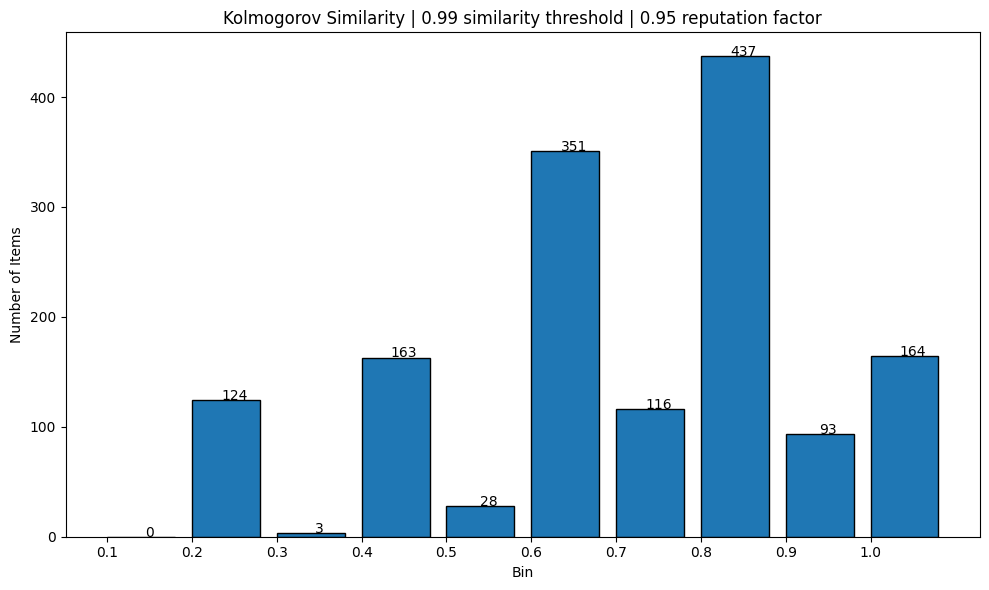

In [79]:
# Assuming user_groups is already defined
cluster_item_ratings = compute_cluster_ratings(df, user_groups)  # Step 1: Compute initial ratings
    

filled_ratings = fill_missing_ratings(cluster_item_ratings)

cluster_item_ratings_reputation = compute_reputation_adjusted_ratings(df, filled_ratings, user_groups)

#calculate average on top3 clusters
item_averages = round_and_average_cluster_ratings(cluster_item_ratings_reputation)
print("item_averages: ", item_averages)
print("len(item_averages): ", len(item_averages))

# Initialize a dictionary to count occurrences of each value between 0.1 and 1.0
value_counts = {round(i * 0.1, 1): 0 for i in range(1, 11)}

# Iterate through the item_averages dictionary and count the occurrences of each value
for value in item_averages.values():
    rounded_value = round(value, 1)
    if rounded_value in value_counts:
        value_counts[rounded_value] += 1

# Extract bins and counts
bins = list(value_counts.keys())
counts = list(value_counts.values())

# Define bin edges from 0.1 to 1.0 (inclusive)
bin_edges = np.arange(0.1, 1.1, 0.1)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(bins, counts, width=0.08, align='edge', edgecolor='black')

# Adding numbers on top of bars
for i in range(len(counts)):
    plt.text(bins[i] + 0.05, counts[i] + 0.1, str(counts[i]), ha='center', fontsize=10)

# Set labels and title
plt.xlabel('Bin')
plt.ylabel('Number of Items')
plt.title('Kolmogorov Similarity | 0.99 similarity threshold | 0.95 reputation factor')

# Adjust the x-axis to display the correct bin edges
plt.xticks(bin_edges)

# Tight layout to avoid clipping
plt.tight_layout()

# Show the plot
plt.show()


